In [1]:
from cnn.model import build_net

from prostate_dataset.dataloader import ProstateDataloader, ProstateDataset, get_training_augmentation, get_validation_augmentation
from prostate_dataset.config import dataset_folder
from prostate_dataset.utils import get_split_deterministic, get_list_of_patients

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], False)
  except RuntimeError as e:
    print(e)

2022-11-21 12:36:03.289845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 12:36:03.419256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 12:36:03.419269: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-21 12:36:04.344472: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
patients = get_list_of_patients(dataset_folder)

In [3]:
patch_size = (128, 128, 2)
batch_size = 32
num_classes = 2
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

net_list = [
    'vgg_n_3',
    'vgg_d_3',
    'vgg_d_3',
    'vgg_d_3',
    'vgg_d_3',
    'vgg_u_3',
    'vgg_u_3',
    'vgg_u_3',
    'vgg_u_3',
    'vgg_n_3'
]

fn_dict =  {
    'den_d_3': {'cell': 'DownscalingCell', 'block': 'DenseBlock',     'kernel': 3},
    'den_d_5': {'cell': 'DownscalingCell', 'block': 'DenseBlock',     'kernel': 5},
    'den_d_7': {'cell': 'DownscalingCell', 'block': 'DenseBlock',     'kernel': 7},
    'den_n_3': {'cell': 'NonscalingCell',  'block': 'DenseBlock',     'kernel': 3},
    'den_n_5': {'cell': 'NonscalingCell',  'block': 'DenseBlock',     'kernel': 5},
    'den_n_7': {'cell': 'NonscalingCell',  'block': 'DenseBlock',     'kernel': 7},
    'den_u_3': {'cell': 'UpscalingCell',   'block': 'DenseBlock',     'kernel': 3},
    'den_u_5': {'cell': 'UpscalingCell',   'block': 'DenseBlock',     'kernel': 5},
    'den_u_7': {'cell': 'UpscalingCell',   'block': 'DenseBlock',     'kernel': 7},
    'inc_d_3': {'cell': 'DownscalingCell', 'block': 'InceptionBlock', 'kernel': 3},
    'inc_d_5': {'cell': 'DownscalingCell', 'block': 'InceptionBlock', 'kernel': 5},
    'inc_d_7': {'cell': 'DownscalingCell', 'block': 'InceptionBlock', 'kernel': 7},
    'inc_n_3': {'cell': 'NonscalingCell',  'block': 'InceptionBlock', 'kernel': 3},
    'inc_n_5': {'cell': 'NonscalingCell',  'block': 'InceptionBlock', 'kernel': 5},
    'inc_n_7': {'cell': 'NonscalingCell',  'block': 'InceptionBlock', 'kernel': 7},
    'inc_u_3': {'cell': 'UpscalingCell',   'block': 'InceptionBlock', 'kernel': 3},
    'inc_u_5': {'cell': 'UpscalingCell',   'block': 'InceptionBlock', 'kernel': 5},
    'inc_u_7': {'cell': 'UpscalingCell',   'block': 'InceptionBlock', 'kernel': 7},
    'ide_d':   {'cell': 'DownscalingCell', 'block': 'IdentityBlock',             },
    'ide_n':   {'cell': 'NonscalingCell',  'block': 'IdentityBlock',             },   
    'ide_u':   {'cell': 'UpscalingCell',   'block': 'IdentityBlock',             },
    'res_d_3': {'cell': 'DownscalingCell', 'block': 'ResNetBlock',    'kernel': 3},
    'res_d_5': {'cell': 'DownscalingCell', 'block': 'ResNetBlock',    'kernel': 5},
    'res_d_7': {'cell': 'DownscalingCell', 'block': 'ResNetBlock',    'kernel': 7},
    'res_n_3': {'cell': 'NonscalingCell',  'block': 'ResNetBlock',    'kernel': 3},
    'res_n_5': {'cell': 'NonscalingCell',  'block': 'ResNetBlock',    'kernel': 5},
    'res_n_7': {'cell': 'NonscalingCell',  'block': 'ResNetBlock',    'kernel': 7},
    'res_u_3': {'cell': 'UpscalingCell',   'block': 'ResNetBlock',    'kernel': 3},
    'res_u_5': {'cell': 'UpscalingCell',   'block': 'ResNetBlock',    'kernel': 5},
    'res_u_7': {'cell': 'UpscalingCell',   'block': 'ResNetBlock',    'kernel': 7},
    'vgg_d_3': {'cell': 'DownscalingCell', 'block': 'VGGBlock',       'kernel': 3},
    'vgg_d_5': {'cell': 'DownscalingCell', 'block': 'VGGBlock',       'kernel': 5},
    'vgg_d_7': {'cell': 'DownscalingCell', 'block': 'VGGBlock',       'kernel': 7},
    'vgg_n_3': {'cell': 'NonscalingCell',  'block': 'VGGBlock',       'kernel': 3},
    'vgg_n_5': {'cell': 'NonscalingCell',  'block': 'VGGBlock',       'kernel': 5},
    'vgg_n_7': {'cell': 'NonscalingCell',  'block': 'VGGBlock',       'kernel': 7},
    'vgg_u_3': {'cell': 'UpscalingCell',   'block': 'VGGBlock',       'kernel': 3},
    'vgg_u_5': {'cell': 'UpscalingCell',   'block': 'VGGBlock',       'kernel': 5},
    'vgg_u_7': {'cell': 'UpscalingCell',   'block': 'VGGBlock',       'kernel': 7},
}

/home/guilherme/Downloads/git/segqnas/.venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


2022-11-21 12:36:07.037632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[0.38072434067726135, 0.3830694854259491, 0.3897468149662018, 0.39397040009498596, 0.40050527453422546, 0.3887668550014496, 0.3956162929534912, 0.3961902856826782, 0.3921620845794678, 0.4026666581630707]


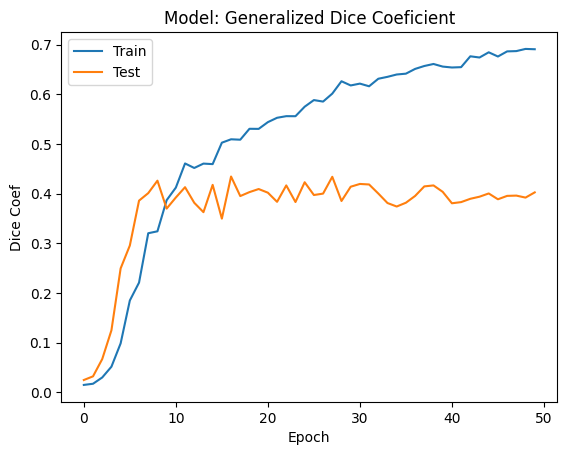

[0.4464062750339508, 0.42938554286956787, 0.44472765922546387, 0.4430570602416992, 0.41249072551727295, 0.4032239615917206, 0.4210189878940582, 0.42978325486183167, 0.4193626642227173, 0.4114912748336792]


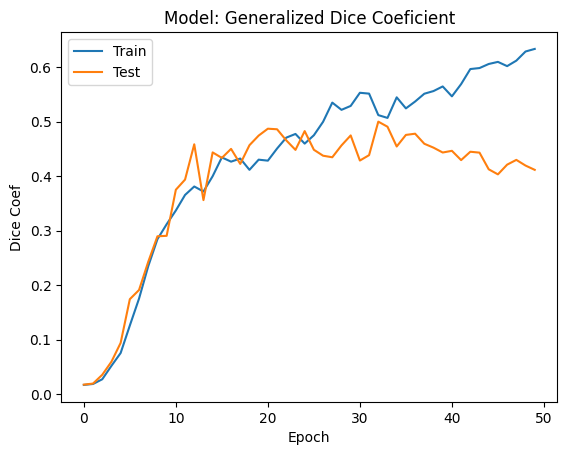

[0.37348687648773193, 0.4137080907821655, 0.4027631878852844, 0.37264484167099, 0.3796932101249695, 0.40865644812583923, 0.37411239743232727, 0.38739287853240967, 0.37827563285827637, 0.39224064350128174]


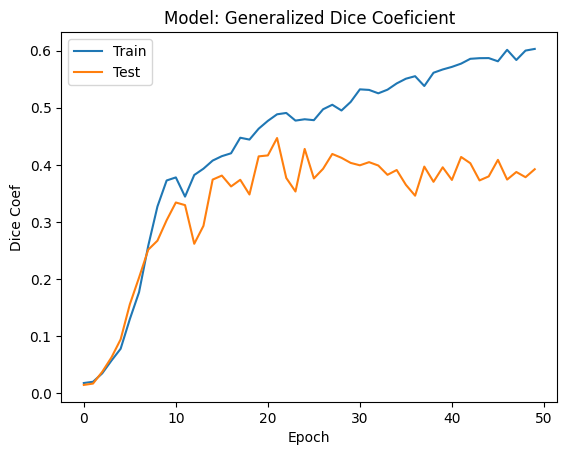

[0.3910296559333801, 0.37758591771125793, 0.36889249086380005, 0.40976449847221375, 0.41682904958724976, 0.3954707980155945, 0.3925667107105255, 0.38718748092651367, 0.388464093208313, 0.38669127225875854]


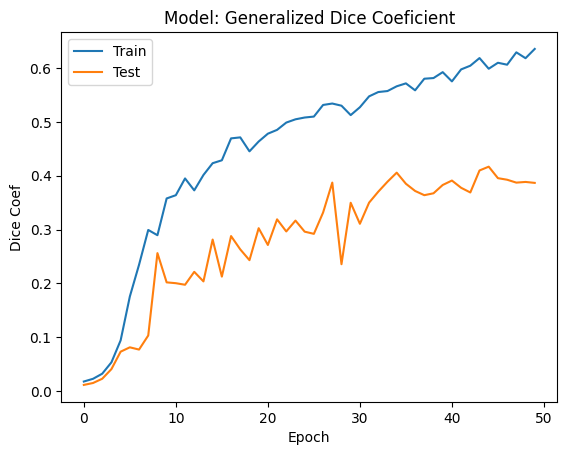

[0.372212678194046, 0.33967819809913635, 0.3500869572162628, 0.36177387833595276, 0.34232211112976074, 0.35793542861938477, 0.35727110505104065, 0.3515976369380951, 0.33800745010375977, 0.3321494162082672]


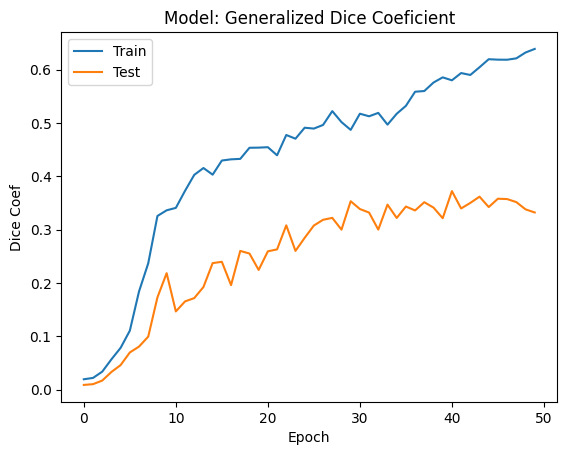

[0.35578182339668274, 0.34397444128990173, 0.3252199590206146, 0.36782777309417725, 0.3455815315246582, 0.3493494987487793, 0.33722615242004395, 0.34652385115623474, 0.35897135734558105, 0.344053715467453]


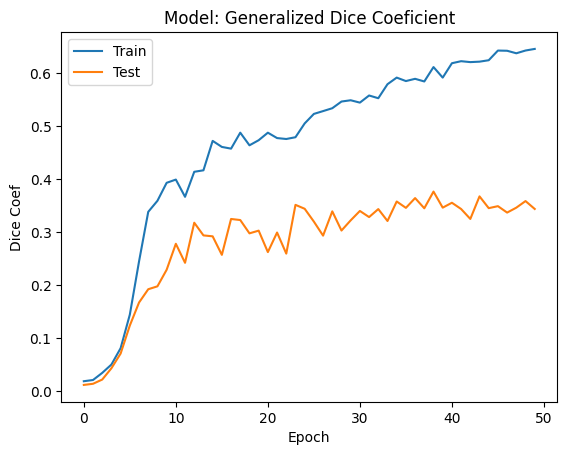

[0.4595622718334198, 0.5030050277709961, 0.4641995429992676, 0.47814854979515076, 0.47687557339668274, 0.4403412342071533, 0.4867802858352661, 0.459826797246933, 0.4673929214477539, 0.473026841878891]


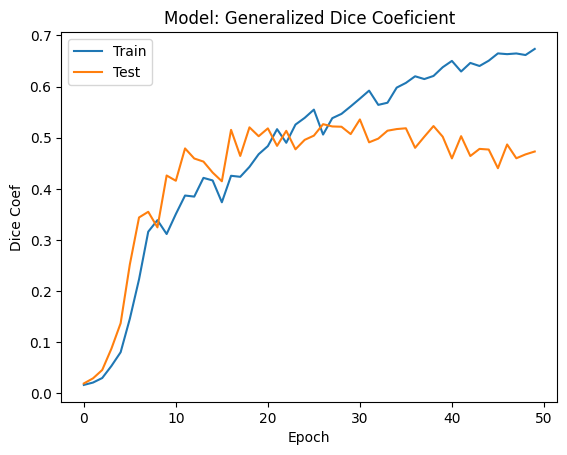

In [4]:
val_gen_dice_coef_list = []
num_splits = 5
num_initializations = 5
epochs = 50
max_depth = 4
stem_filters = 16
evaluation_epochs = 10

for initialization in range(num_initializations):

    for fold in range(num_splits):
        train_patients, val_patients = get_split_deterministic(patients, fold=fold, num_splits=num_splits, random_state=initialization)

        train_dataset = ProstateDataset(train_patients, only_non_empty_slices=True)
        val_dataset = ProstateDataset(val_patients, only_non_empty_slices=True)

        train_dataloader = ProstateDataloader(train_dataset, batch_size, train_augmentation)
        val_dataloader = ProstateDataloader(val_dataset, batch_size, val_augmentation)

        model = build_net(patch_size, stem_filters, max_depth, num_classes, fn_dict, net_list)
 
        def learning_rate_fn(epoch):
            initial_learning_rate = 1e-3
            end_learning_rate = 1e-4
            power = 0.9
            return ((initial_learning_rate - end_learning_rate) *
                (1 - epoch / float(epochs)) ** (power)
                ) + end_learning_rate
            
        lr_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn, verbose=False)

        history = model.fit(
            train_dataloader,
            validation_data=val_dataloader,
            epochs=epochs,
            verbose=0,
            callbacks=[
                lr_callback
            ]
        )
        
        print(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        val_gen_dice_coef_list.extend(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        # for patient in val_patients:
        #     patient_dataset = ProstateDataset([patient], only_non_empty_slices=True)
        #     patient_dataloader = ProstateDataloader(patient_dataset, 1, val_augmentation, shuffle=False)
        #     results = model.evaluate(patient_dataloader)
        #     val_gen_dice_coef_patient = results[-1]
        #     val_gen_dice_coef_list.append(val_gen_dice_coef_patient)

        #plotting the dice coef results (accuracy) as a function of the number of epochs
        plt.figure()
        plt.plot(history.history['gen_dice_coef'])
        plt.plot(history.history['val_gen_dice_coef'])
        plt.title('Model: Generalized Dice Coeficient')
        plt.ylabel('Dice Coef')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        #plotting the dice coef results (loss function) as a function of the number of epochs
        # plt.figure()
        # plt.plot(history.history['loss'])
        # plt.plot(history.history['val_loss'])
        # plt.title('Model: Generalized Dice Coeficient')
        # plt.ylabel('Dice Loss')
        # plt.xlabel('Epoch')
        # plt.legend(['Train', 'Test'], loc='upper right')
        # plt.show()

mean_val_gen_dice_coef = (np.mean(val_gen_dice_coef_list))
std_val_gen_dice_coef = (np.std(val_gen_dice_coef_list))

print(f'Dice {mean_val_gen_dice_coef} +- {std_val_gen_dice_coef}')